CS4001/4042 Assignment 1, Part B, Q3
---

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [1]:
!pip install captum -q

In [2]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

> First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [18]:
# TODO: Enter your code here
df = pd.read_csv('hdb_price_prediction.csv')
target = ['resale_price']
num_col_names = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
cat_col_names = ['month', 'town', 'flat_model_type', 'storey_range']
df = df.drop(columns=cat_col_names)

mask_train = (df['year']<=2019)
mask_val = (df['year']==2020)
mask_test = (df['year']==2021)

train = df.loc[mask_train]
X_train = train[num_col_names].to_numpy()
y_train = train[target].to_numpy()

val = df.loc[mask_val]
X_val = val[num_col_names].to_numpy()
y_val = val[target].to_numpy()

test = df.loc[mask_test]
X_test = test[num_col_names].to_numpy()
y_test = test[target].to_numpy()

> Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


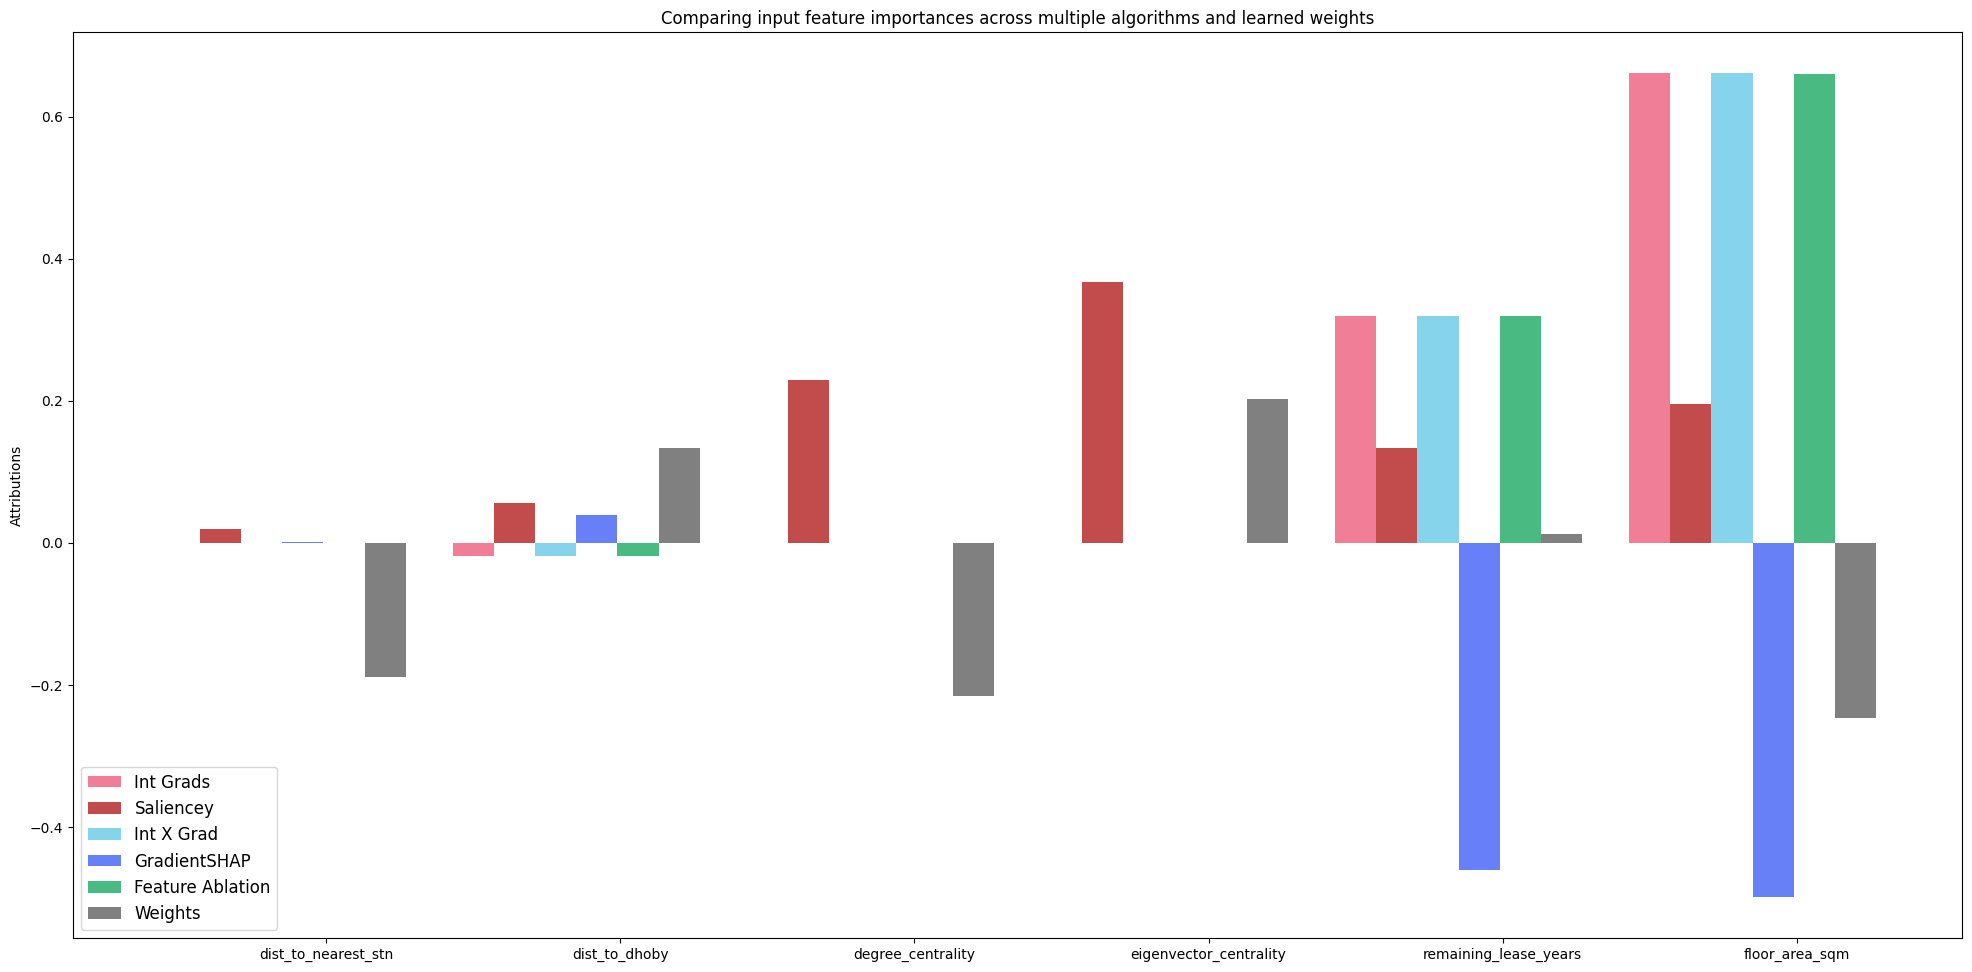

In [22]:
# TODO: Enter your code here
import tqdm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

class HDBModel(nn.Module):
    def __init__(self, no_features, num_neurons, output_size):
        super().__init__()
        self.stack = nn.Sequential()
        self.stack.append(nn.Linear(no_features, num_neurons))
        self.stack.append(nn.ReLU())
        for i in range(2):
            self.stack.append(nn.Linear(num_neurons, num_neurons))
            self.stack.append(nn.ReLU())
        self.stack.append(nn.Linear(num_neurons, output_size))

    def forward(self, x):
        return self.stack(x)

def train_loop(train_dataloader, model, loss_fn, optimizer):
    size = len(train_dataloader)
    train_loss = 0
    for X,y in train_dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= size
    return train_loss

## Dataloaders
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(datasets, batch_size=128, shuffle=True)

val_datasets = torch.utils.data.TensorDataset(X_val, y_val)
val_dataloader = torch.utils.data.DataLoader(datasets, batch_size=128, shuffle=True)

test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(datasets, batch_size=128, shuffle=True)

## Training params
no_features = X_train.shape[1]
output_size = 1
num_neurons = 5
model = HDBModel(no_features, num_neurons, output_size)
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = nn.MSELoss()
num_epochs = 20
train_loss_ = []

## Training
for epoch in tqdm.tqdm(range(num_epochs)):
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    # print(f"Train loss: {train_loss}")
    train_loss_.append(train_loss)

## Eval
model.eval()
outputs = model(X_val)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_val.detach().numpy()))
print('model err: ', err)

## Captum
ig = IntegratedGradients(model)
sl = Saliency(model)
ixg = InputXGradient(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

subset_size = 2048

ig_attr_test = ig.attribute(X_test[:subset_size], n_steps=50)
sl_attr_test = sl.attribute(X_test[:subset_size])
ixg_attr_test = ixg.attribute(X_test[:subset_size])
gs_attr_test = gs.attribute(X_test[:subset_size], X_train)
fa_attr_test = fa.attribute(X_test[:subset_size])

## Plotting - adapted from https://captum.ai/tutorials/House_Prices_Regression_Interpret

def get_captum_results(captum_attr):
    captum_attr_sum = captum_attr.detach().numpy().sum(0)
    captum_attr_norm_sum = captum_attr_sum / np.linalg.norm(captum_attr_sum, ord=1)
    return captum_attr_norm_sum

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: num_col_names[idx], x_axis_data))

ig_attr_test_norm_sum = get_captum_results(ig_attr_test)
sl_attr_test_norm_sum = get_captum_results(sl_attr_test)
ixg_attr_test_norm_sum = get_captum_results(ixg_attr_test)
gs_attr_test_norm_sum = get_captum_results(gs_attr_test)
fa_attr_test_norm_sum = get_captum_results(fa_attr_test)

lin_weight = model.stack[0].weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Saliencey', 'Int X Grad','GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, sl_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, ixg_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

> Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


100%|██████████| 20/20 [00:43<00:00,  2.17s/it]


model err:  90502.016


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


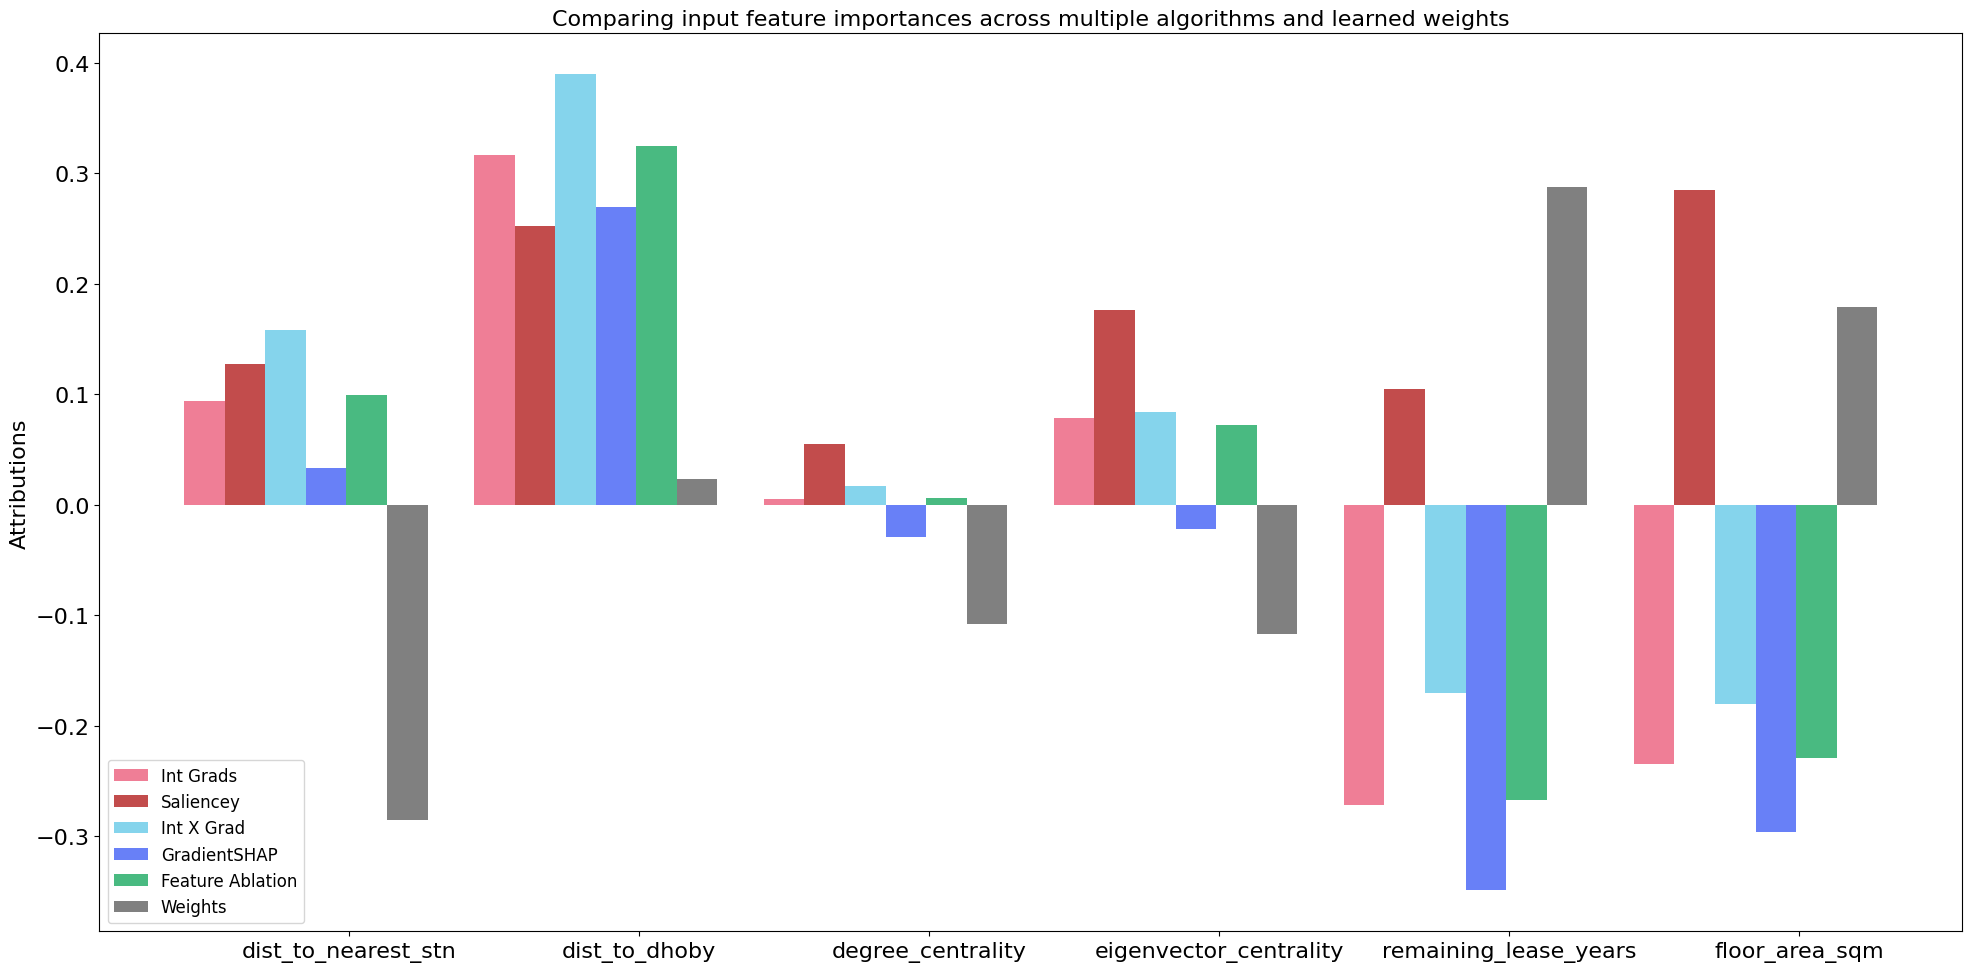

In [32]:
"""
Gradient SHAP adds Gaussian noise to each input sample multiple times, selects a random point along the path between baseline and input,
and computes the gradient of outputs with respect to those selected random points.
The final SHAP values represent the expected value of gradients * (inputs - baselines).

We see that GradientShap is large in magnitude for dist_to_dhoby, remaining_lease_years and floor_area_sqm.
This could be due to those features having larger gradient values thus gradients * (inputs - baselines) are larger.
The difference in sign (positive for dist_to_dhoby, negative for the other two) could be due to the gradients computed.
This indicates that remaining_lease_years and floor_area_sqm actually decrease resale_price which is unintuitive.
However, the other gradient-based indicators imply otherwise.

From the Captum tutorial, it is noted that -

' Zero weight means no correlation whereas positive weights indicate positive correlations and negatives the opposite.
Since the network has more than one layer these weights might not be directly correlated with the price.

We also note that GradientShap behaves differently than the other methods for this data and model.
Whereas the other methods in this tutorial are calculated on test inputs and a reference baseline of zero,
GradientShap is calculated with a baseline of the training distribution which might be the cause of the behavior observed. '

This implies that looking at GradientSHAP alone may not be reliable, and also it may be more reliable to solely inspect the magnitude of the feature attributions.
"""


# TODO: Enter your code here
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

## Scaled data
X_train_scaled = ss.fit_transform(X_train)
X_train_scaled = torch.tensor(X_train_scaled).float()

X_val_scaled = ss.transform(X_val)
X_val_scaled = torch.tensor(X_val_scaled).float()

X_test_scaled = ss.transform(X_test)
X_test_scaled = torch.tensor(X_test_scaled).float()

scaled_datasets = torch.utils.data.TensorDataset(X_train_scaled, y_train)
scaled_train_dataloader = torch.utils.data.DataLoader(scaled_datasets, batch_size=128, shuffle=True)

# val_datasets = torch.utils.data.TensorDataset(X_val_scaled, y_val)
# val_iter = torch.utils.data.DataLoader(datasets, batch_size=128, shuffle=True)

# test_datasets = torch.utils.data.TensorDataset(X_test_scaled, y_test)
# test_iter = torch.utils.data.DataLoader(datasets, batch_size=128, shuffle=True)

## Training params
no_features = X_train.shape[1]
output_size = 1
num_neurons = 5
model = HDBModel(no_features, num_neurons, output_size)
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = nn.MSELoss()
num_epochs = 20
train_loss_ = []

## Training
for epoch in tqdm.tqdm(range(num_epochs)):
    train_loss = train_loop(scaled_train_dataloader, model, loss_fn, optimizer)
    # print(f"Train loss: {train_loss}")
    train_loss_.append(train_loss)

## Eval
model.eval()
outputs = model(X_val_scaled)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_val.detach().numpy()))
print('model err: ', err)

## Captum
ig = IntegratedGradients(model)
sl = Saliency(model)
ixg = InputXGradient(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

subset_size = 2048

ig_attr_test_scaled = ig.attribute(X_test_scaled[:subset_size], n_steps=50)
sl_attr_test_scaled = sl.attribute(X_test_scaled[:subset_size])
ixg_attr_test_scaled = ixg.attribute(X_test_scaled[:subset_size])
gs_attr_test_scaled = gs.attribute(X_test_scaled[:subset_size], X_train_scaled)
fa_attr_test_scaled = fa.attribute(X_test_scaled[:subset_size])

## Plotting - adapted from https://captum.ai/tutorials/House_Prices_Regression_Interpret

def get_captum_results(captum_attr):
    captum_attr_sum = captum_attr.detach().numpy().sum(0)
    captum_attr_norm_sum = captum_attr_sum / np.linalg.norm(captum_attr_sum, ord=1)
    return captum_attr_norm_sum

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: num_col_names[idx], x_axis_data))

ig_attr_test_scaled_norm_sum = get_captum_results(ig_attr_test_scaled)
sl_attr_test_scaled_norm_sum = get_captum_results(sl_attr_test_scaled)
ixg_attr_test_scaled_norm_sum = get_captum_results(ixg_attr_test_scaled)
gs_attr_test_scaled_norm_sum = get_captum_results(gs_attr_test_scaled)
fa_attr_test_scaled_norm_sum = get_captum_results(fa_attr_test_scaled)

lin_weight = model.stack[0].weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Saliencey', 'Int X Grad','GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_scaled_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, sl_attr_test_scaled_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, ixg_attr_test_scaled_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_scaled_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_scaled_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

> Why did Saliency produce scores similar to IG?


\<From the plots, we can see that Saliency and IG produce similar scores (in magnitude) for the features **dist_to_nearest_stn**, **dist_to_dhoby**, and **floor_area_sqm** but not for **remaining_lease_years**, **eigenvector_centrality** and **degree_centrality**

To understand this, we need to understand the differences between Saliency and IG -

Saliency measures the importance of each feature in the input with respect to the output produced by taking partial derivatives of the output wrt to each input feature. However, this may result in saturation, where the gradients of input features may have small magnitudes (at some point in training) around a sample even if the network depends heavily on those features

IG measures feature importance by taking the integral of the gradients of the input along a path from a baseline input to the actual input and multiplies with (input - baseline). By doing this, it overcomes the problem of saturation and provides a more cohesive picture of the feature's importance

Thus, we would expect Saliency and IG to behave similarly if the p.d. of output wrt the feature is similar to its integral from a baseline (e.g. 0) to the actual input. For our dataset, it appears that **dist_to_nearest_stn**, **dist_to_dhoby**, and **floor_area_sqm** fit the criteria while **remaining_lease_years**, **eigenvector_centrality** and **degree_centrality** do not\>

> Why did Input x Gradients give the same attribution scores as IG?


\<Both Input x Gradients and IG use similar methods for feature importance calculation. IXG multiplies the partial derivatives (gradients) by the input value and is an extension of Saliency, which results in an approximation of the integral of the gradients, similar to a Riemann sum. IG also approximates the integral of the gradients along the path from baseline to input and multiplies with (input - baseline), thus they provide similar results with some difference in magnitude due to the latter multiplying by (input - baseline).\>